In [2]:
import pandas as pd

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [50]:
from collections import Counter

In [8]:
import matplotlib.pyplot as plt

In [9]:
import seaborn as sns

In [14]:
from scipy import stats

In [10]:
from scipy.stats import anderson, skew, kurtosis, zscore

In [11]:
from sklearn.impute import KNNImputer

In [12]:
import datetime as dt

In [13]:
import numpy as np

In [16]:
data = pd.read_csv('avito_data.csv')

In [18]:
# infos about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1760 non-null   int64  
 1   title         1400 non-null   object 
 2   price         1400 non-null   object 
 3   city          1400 non-null   object 
 4   datetime      1394 non-null   object 
 5   nb_rooms      1193 non-null   float64
 6   nb_baths      1181 non-null   object 
 7   surface_area  990 non-null    object 
 8   equipement    868 non-null    object 
 9   link          1760 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 137.6+ KB


In [19]:
# first few rows
data.head()

,Unnamed: 0,title,price,city,datetime,nb_rooms,nb_baths,surface_area,equipement,link
0,0,CMN-MA-1641 - Appartement à vendre à Val Fleurie,1 600 000 DH,Casablanca,"11/6/2024, 12:12:49 PM",3.0,1,132,"Ascenseur, Balcon, Parking, Terrasse",https://www.avito.ma/fr/val_fleuri/appartement...
1,1,Appartement à vendre 125 m² à Casablanca,9 900 DH,Casablanca,"11/6/2024, 12:12:26 PM",2.0,2,125,"Balcon, Climatisation, Cuisine Équipée, Parkin...",https://www.avito.ma/fr/autre_secteur/appartem...
2,2,CMN-MA-1787 - Appartement à vendre à Les Hôpitaux,2 300 000 DH,Casablanca,"11/6/2024, 12:10:48 PM",3.0,2,233,"Ascenseur, Balcon, Parking, Terrasse",https://www.avito.ma/fr/quartier_des_h%C3%B4pi...
3,3,Appartement à vendre 3 chambres Salon à Casa,PRIX NON SPÉCIFIÉ,Casablanca,"11/6/2024, 12:10:57 PM",NaN,NaN,NaN,NaN,https://www.avito.ma/fr/ain_sebaa/appartements...
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://immoneuf.avito.ma/fr/unite/l53?utm_sou...


In [20]:
data['price'] = data['price'].replace('PRIX NON SPÉCIFIÉ', np.nan)
# replacing string in the price column
data['price'] = data['price'].astype(str).str.replace(r'\u202f| DH', '', regex=True).astype(float)

In [21]:
data['price']

0       1600000.0
1          9900.0
2       2300000.0
3             NaN
4             NaN
          ...    
1755          NaN
1756    3300000.0
1757    3500000.0
1758     990000.0
1759          NaN
Name: price, Length: 1760, dtype: float64

In [22]:
# Exemple de conversion sur la colonne 'nb_baths'
data['nb_baths'] = pd.to_numeric(data['nb_baths'], errors='coerce')
# Replace NaN values with 0 (or any other integer) and convert to int
data['nb_baths'] = data['nb_baths'].fillna(0).astype(int)
data['nb_baths']

0       1
1       2
2       2
3       0
4       0
       ..
1755    0
1756    2
1757    2
1758    2
1759    0
Name: nb_baths, Length: 1760, dtype: int64

In [23]:
# Exemple de conversion sur la colonne 'surface_area'
data['surface_area'] = pd.to_numeric(data['surface_area'], errors='coerce')
data['surface_area']

0       132.0
1       125.0
2       233.0
3         NaN
4         NaN
        ...  
1755      NaN
1756    154.0
1757    170.0
1758    117.0
1759      NaN
Name: surface_area, Length: 1760, dtype: float64

In [24]:
data['nb_rooms'] = data['nb_rooms'].fillna(0).astype(int)
data['nb_rooms']

0       3
1       2
2       3
3       0
4       0
       ..
1755    0
1756    3
1757    3
1758    2
1759    0
Name: nb_rooms, Length: 1760, dtype: int64

In [25]:
# Calcul des statistiques descriptives complètes
full_numerical_stats = data.describe()

# Calcul des médianes et des moyennes pour comparer les distributions
medians = data[['price', 'nb_rooms', 'nb_baths', 'surface_area']].median()
means = data[['price', 'nb_rooms', 'nb_baths', 'surface_area']].mean()

asymmetry = pd.DataFrame({
    "Moyenne": means,
    "Médiane": medians,
    "Différence (Moyenne - Médiane)": means - medians
})

asymmetry

,Moyenne,Médiane,Différence (Moyenne - Médiane)
price,2.014280e+06,1050000.0,964280.017603
nb_rooms,1.622727e+00,2.0,-0.377273
nb_baths,8.672159e+00,1.0,7.672159
surface_area,1.071418e+02,96.0,11.141844


## Analyse des différences

Pour évaluer la symétrie de chaque distribution, nous comparons la moyenne et la médiane de chaque colonne numérique. Une différence significative entre ces deux valeurs indique une distribution asymétrique, ce qui influence notre choix de méthode d’imputation.

| Colonne       | Moyenne         | Médiane        | Différence (Moyenne - Médiane) | Analyse de la Distribution                                    | Méthode d’Imputation Recommandée |
|---------------|-----------------|----------------|--------------------------------|----------------------------------------------------------------|----------------------------------|
| **price**     | 2,014,280       | 1,050,000      | 964,280                        | Distribution asymétrique due aux valeurs extrêmes.            | **Médiane**                     |
| **nb_rooms**  | 1.62            | 2              | 0.37                           | Distribution symétrique.                                      | **Moyenne**                     |
| **nb_baths**  | 8.67           | 1              | 7.67                          | Distribution asymétrique, probablement due à des outliers.    | **Médiane**                     |
| **surface_area** | 107.14       | 96             | 11.14                          | Distribution légèrement asymétrique.                          | **Médiane**                     |

### Conclusion

Pour les colonnes présentant une distribution asymétrique (comme **price**, **nb_baths** et **surface_area**), la **médiane** est utilisée pour l’imputation afin de minimiser l'influence des valeurs extrêmes. En revanche, pour **nb_rooms**, où la distribution est symétrique, la **moyenne** est plus appropriée.

## Imputation Selected

In [26]:
# Imputation selon les analyses
data['price'] = data['price'].fillna(data['price'].median())  # Médiane pour price
data['nb_rooms'] = data['nb_rooms'].fillna(data['nb_rooms'].mean())  # Moyenne pour nb_rooms
data['nb_baths'] = data['nb_baths'].fillna(data['nb_baths'].median())  # Médiane pour nb_baths
data['surface_area'] = data['surface_area'].fillna(data['surface_area'].median())  # Médiane pour surface_area

In [40]:
# Check for remaining missing values
missing_data = data.isnull().sum()
print(missing_data)

Unnamed: 0      0
title           0
price           0
city            0
datetime        0
nb_rooms        0
nb_baths        0
surface_area    0
equipement      0
link            0
dtype: int64


In [28]:
# Impute categorical columns using mode (most frequent value)
data['title'] = data['title'].fillna(data['title'].mode()[0])
data['city'] = data['city'].fillna(data['city'].mode()[0])
data['equipement'] = data['equipement'].fillna(data['equipement'].mode()[0])

In [29]:
# Example data (if datetime column is not in datetime format already)
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')

In [30]:
# impute datetime column using mode
data['datetime'] = data['datetime'].fillna(data['datetime'].mode()[0])

# Détection et Traitement des Valeurs Aberrantes
### Assessing Distribution of Data : ***Normality***

#### **1. Anderson-Darling ***>>*** To Check Normality**


Analysis for column: price


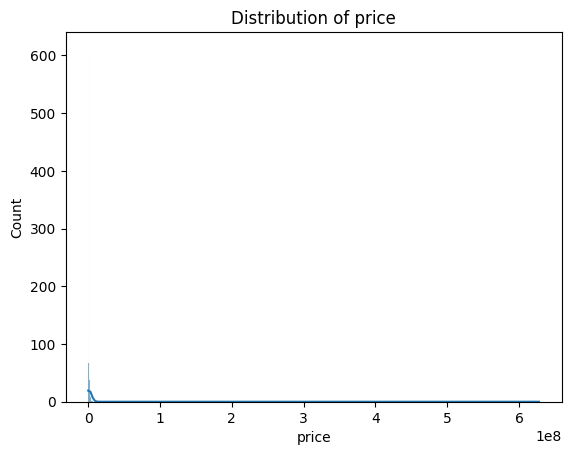

Statistic for price: 607.8782121178683
Critical Values for price: [0.575 0.655 0.785 0.916 1.09 ]
Significance Levels for price: [15.  10.   5.   2.5  1. ]
The data for price is likely NOT normal at 15.0% significance level
The data for price is likely NOT normal at 10.0% significance level
The data for price is likely NOT normal at 5.0% significance level
The data for price is likely NOT normal at 2.5% significance level
The data for price is likely NOT normal at 1.0% significance level

Analysis for column: nb_rooms


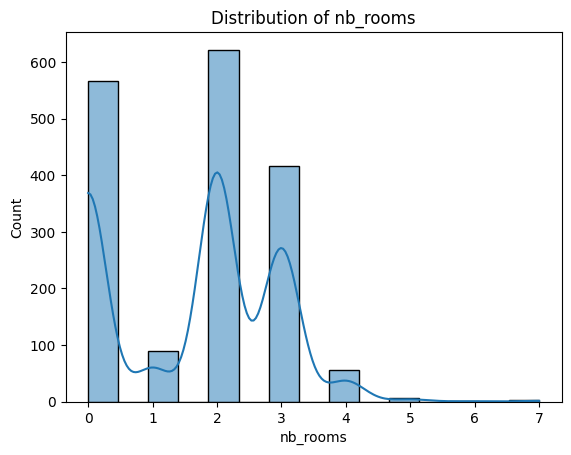

Statistic for nb_rooms: 115.25263092152159
Critical Values for nb_rooms: [0.575 0.655 0.785 0.916 1.09 ]
Significance Levels for nb_rooms: [15.  10.   5.   2.5  1. ]
The data for nb_rooms is likely NOT normal at 15.0% significance level
The data for nb_rooms is likely NOT normal at 10.0% significance level
The data for nb_rooms is likely NOT normal at 5.0% significance level
The data for nb_rooms is likely NOT normal at 2.5% significance level
The data for nb_rooms is likely NOT normal at 1.0% significance level

Analysis for column: nb_baths


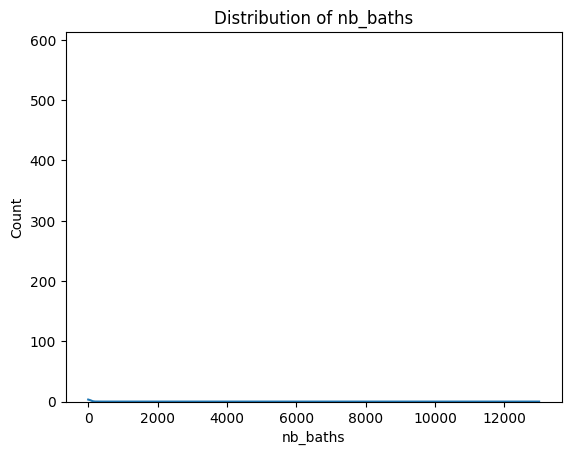

Statistic for nb_baths: 673.4380593204205
Critical Values for nb_baths: [0.575 0.655 0.785 0.916 1.09 ]
Significance Levels for nb_baths: [15.  10.   5.   2.5  1. ]
The data for nb_baths is likely NOT normal at 15.0% significance level
The data for nb_baths is likely NOT normal at 10.0% significance level
The data for nb_baths is likely NOT normal at 5.0% significance level
The data for nb_baths is likely NOT normal at 2.5% significance level
The data for nb_baths is likely NOT normal at 1.0% significance level

Analysis for column: surface_area


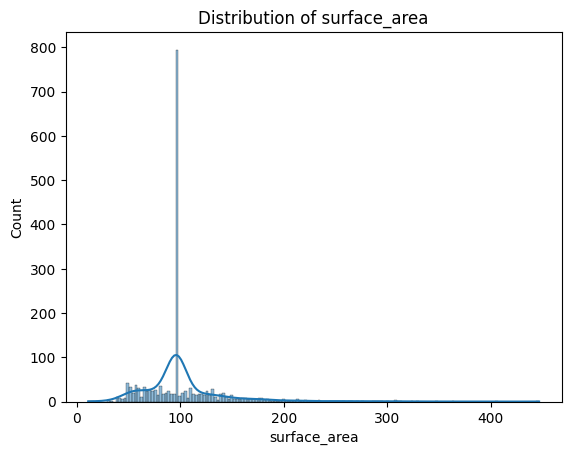

Statistic for surface_area: 134.05132309106466
Critical Values for surface_area: [0.575 0.655 0.785 0.916 1.09 ]
Significance Levels for surface_area: [15.  10.   5.   2.5  1. ]
The data for surface_area is likely NOT normal at 15.0% significance level
The data for surface_area is likely NOT normal at 10.0% significance level
The data for surface_area is likely NOT normal at 5.0% significance level
The data for surface_area is likely NOT normal at 2.5% significance level
The data for surface_area is likely NOT normal at 1.0% significance level


In [37]:
# List of numerical columns to check
numerical_columns = ['price', 'nb_rooms', 'nb_baths', 'surface_area']

# Loop through each numerical column
for column in numerical_columns:
    print(f"\nAnalysis for column: {column}")
    
    # Step 1: Visualize the distribution
    sns.histplot(data[column].dropna(), kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

    # Step 2: Anderson-Darling Test for Normality
    result = anderson(data[column].dropna())  # Drop NaN values for the test
    print(f"Statistic for {column}: {result.statistic}")
    print(f"Critical Values for {column}: {result.critical_values}")
    print(f"Significance Levels for {column}: {result.significance_level}")
    
    # Step 3: Compare Anderson-Darling statistic with critical values
    for sl, cv in zip(result.significance_level, result.critical_values):
        if result.statistic > cv:
            print(f"The data for {column} is likely NOT normal at {sl}% significance level")
        else:
            print(f"The data for {column} is likely normal at {sl}% significance level")

#### Applying **Z-score** ***or*** **IQR**
**Given that the Anderson-Darling test suggests my data is not normally distributed, ***IQR*** is generally the better method to detect outliers because:**

   **It is robust to non-normality and can handle skewed distributions, which is the case with my data.**
    **Z-scores might not be accurate for my data since it deviates from normality, especially at higher or lower tails where extreme values (outliers) might occur.**

In [41]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(df, columns):
    outliers = {}
    
    for column in columns:
        # Calculate Q1, Q3 and IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate the lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Find outliers
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        # Print outliers count
        print(f"\nOutliers in {column}: {outliers[column].shape[0]} outliers")
        print(outliers[column][[column]])  # Showing the outlier values in that column
    
    return outliers

# Detect outliers in your dataset
outliers = detect_outliers_iqr(data, numerical_columns)


Outliers in price: 138 outliers
          price
5     3000000.0
12    2970000.0
56    3500000.0
67    2850000.0
76    3300000.0
...         ...
1741  3000000.0
1742  2750000.0
1752  3000000.0
1756  3300000.0
1757  3500000.0

[138 rows x 1 columns]

Outliers in nb_rooms: 0 outliers
Empty DataFrame
Columns: [nb_rooms]
Index: []

Outliers in nb_baths: 6 outliers
      nb_baths
344         36
495        106
556      13000
665         53
998        110
1645        58

Outliers in surface_area: 481 outliers
      surface_area
0            132.0
2            233.0
5            202.0
8            212.0
11           160.0
...            ...
1742         294.0
1744          60.0
1752         199.0
1756         154.0
1757         170.0

[481 rows x 1 columns]


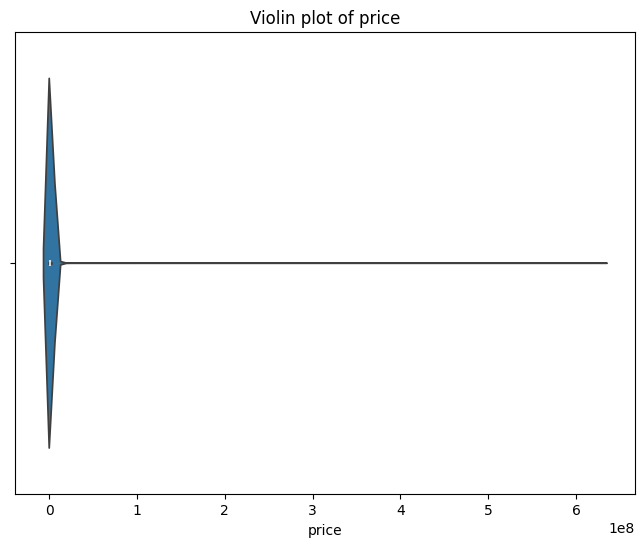

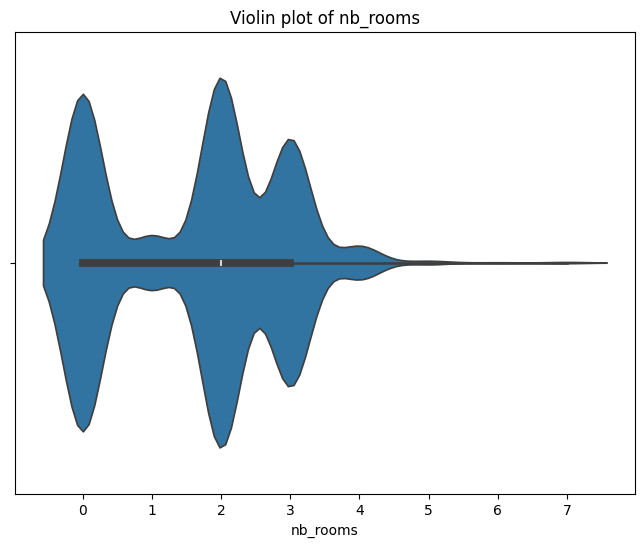

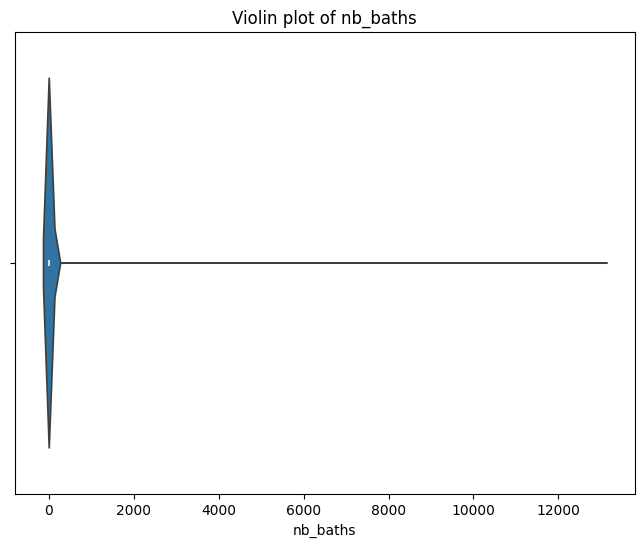

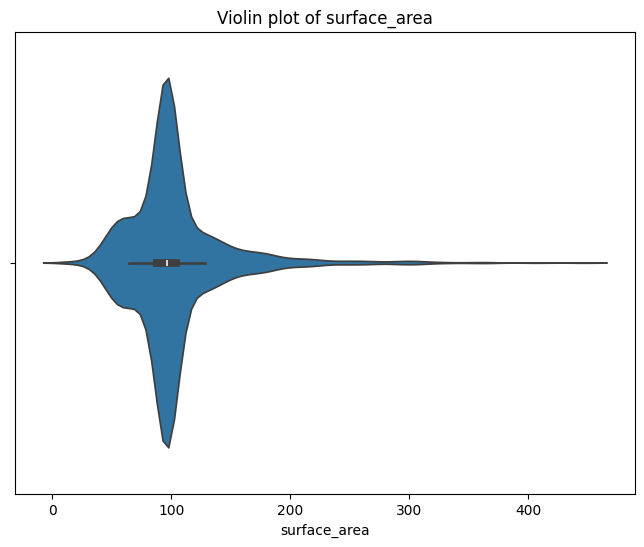

In [43]:
# List of numerical columns to check
numerical_columns = ['price', 'nb_rooms', 'nb_baths', 'surface_area']

# Loop through each numerical column and create a violin plot
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=data[column])
    plt.title(f'Violin plot of {column}')
    plt.show()

#### **Plot Interpretation**
***Violin Plot:*** This plot represents data ('price', 'nb_rooms', 'nb_baths', 'surface_area') distribution, including median, interquartile range, and data density estimation. Additionally, it displays the outliers with the representation showing how the data spreads.

### Summary of General Interpretation:

***Outliers in price:*** There are significant outliers in the price data, with values in the range of 3 to 3.5 million. These should be reviewed to see if they are correct or erroneous.

***Outliers in nb_rooms:*** No outliers were detected in the number of rooms, suggesting this variable is stable across your dataset.

***Outliers in nb_baths:*** There are a few extreme values that likely represent data entry errors or special properties. These should be reviewed further to decide if they should be kept or removed.

***Outliers in surface_area:*** Many outliers were detected, suggesting that there are properties with either very small or very large surface areas. This could be due to the inclusion of diverse property types (e.g., small apartments vs. large estates).

#### Standarization or Normalization
Since the ***Anderson-Darling*** test shows that columns such as price, nb_rooms, nb_baths, and surface_area may not come from a normal distribution, it would be more proper to normalize the data instead of standardizing it.

In [46]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# List of numerical columns to normalize
numerical_columns = ['price', 'nb_rooms', 'nb_baths', 'surface_area']

# Apply Min-Max normalization to the selected columns directly
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
data[numerical_columns].head()

,price,nb_rooms,nb_baths,surface_area
0,0.002548,0.428571,0.000077,0.277523
1,0.000016,0.285714,0.000154,0.261468
2,0.003663,0.428571,0.000154,0.509174
3,0.001672,0.000000,0.000000,0.194954
4,0.001672,0.000000,0.000000,0.194954


#### Plotting Data Distribution after normalization

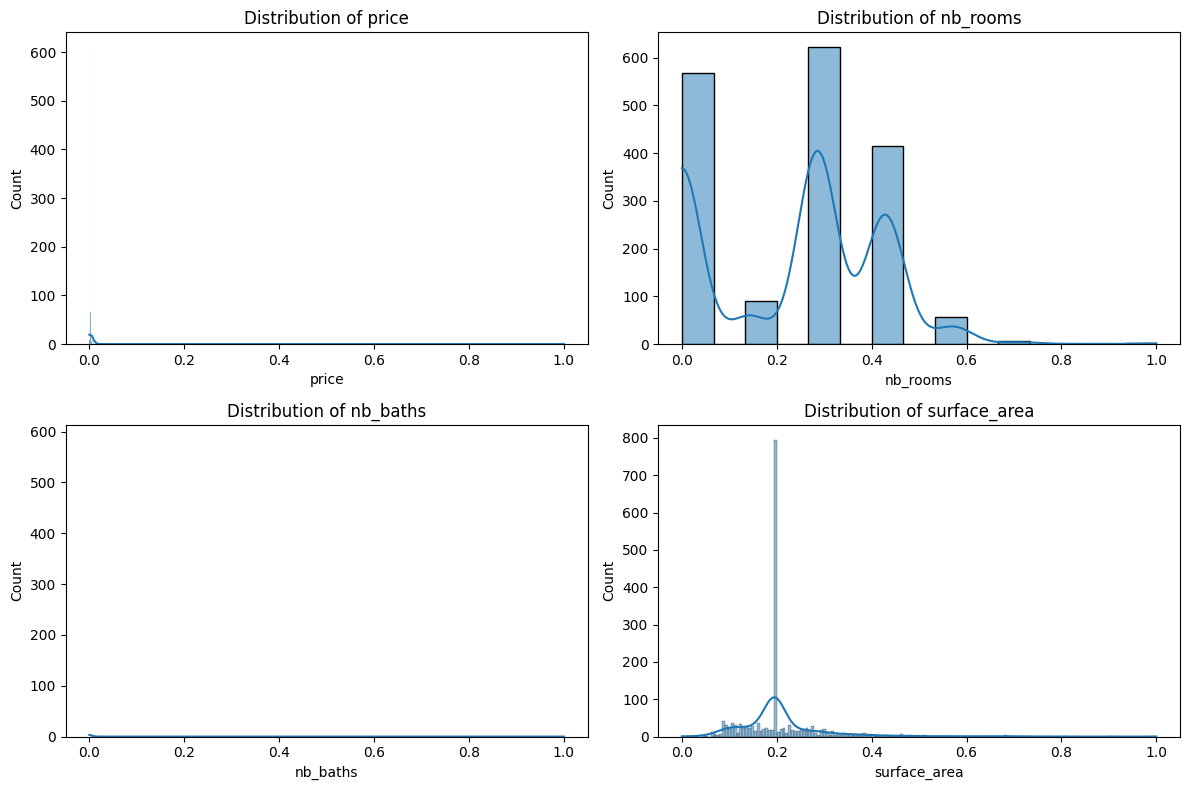

In [47]:
# Plot the distribution of each normalized column
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Gestion des Données Déséquilibrées
**SMOT**

SMOTE is an acronym for Synthetic Minority Over-sampling Technique employed in eliminating imbalance within a dataset. It often happens that one class has fewer examples than the other class and may be referred to as the minority and majority class, respectively. Hence, SMOTE is employed as a popular technique of creating synthetic examples of the minority class to balance the dataset.

equipement_grouped
Ascenseur    1541
Balcon        149
Other          38
Parking        32
Name: count, dtype: int64


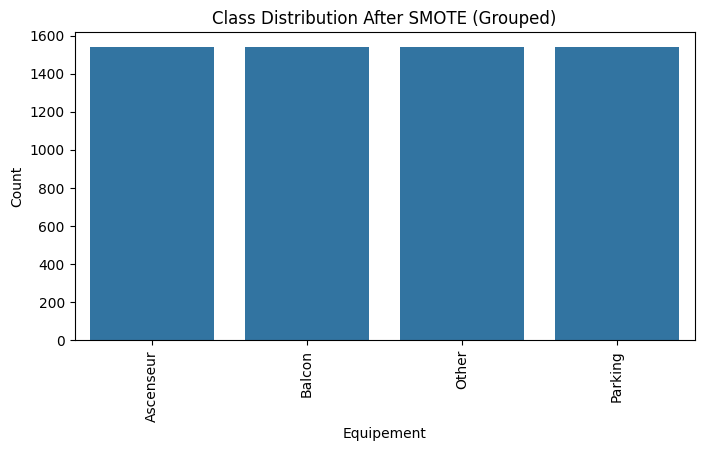

In [70]:
# Example of grouping 'equipement' combinations into broader categories

# Grouping combinations based on the presence of key features
data['equipement_grouped'] = data['equipement'].apply(lambda x: 
    'Ascenseur' if 'Ascenseur' in x else 
    ('Balcon' if 'Balcon' in x else 
     ('Parking' if 'Parking' in x else 'Other'))
)

# Check the new class distribution
print(data['equipement_grouped'].value_counts())

# Reassign y as the grouped 'equipement' column
y_grouped = data['equipement_grouped']

# Apply SMOTE on the new grouped categories
smote = SMOTE(k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y_grouped)

# Plot class distribution after applying SMOTE
plt.figure(figsize=(8, 4))
sns.countplot(x=y_resampled)
plt.title("Class Distribution After SMOTE (Grouped)")
plt.xlabel("Equipement")
plt.ylabel("Count")
plt.xticks(rotation=90)  # Rotate x labels if needed for better readability
plt.show()

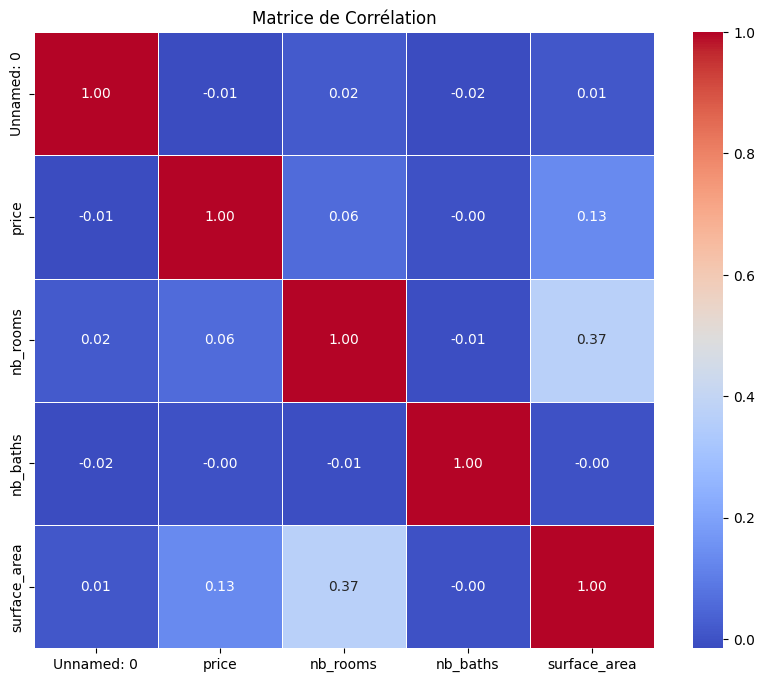

In [72]:
# Sélectionner uniquement les colonnes numériques
numeric_data = data.select_dtypes(include=['number'])

# Calculer la matrice de corrélation
correlation_matrix = numeric_data.corr()

# Visualiser la matrice de corrélation avec un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()


## PCA & Correlation

In [73]:
# Seuil pour la corrélation
threshold = 0.9

# Trouver les caractéristiques fortement corrélées
high_corr_var = [column for column in correlation_matrix.columns if any(correlation_matrix[column] > threshold)]
print("Caractéristiques fortement corrélées:", high_corr_var)

# Suppression des variables fortement corrélées
data_reduced = data.drop(columns=high_corr_var)

Caractéristiques fortement corrélées: ['Unnamed: 0', 'price', 'nb_rooms', 'nb_baths', 'surface_area']


In [75]:
from sklearn.preprocessing import StandardScaler
# Sélectionner les colonnes numériques pour la PCA
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
X = data[numerical_features]

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

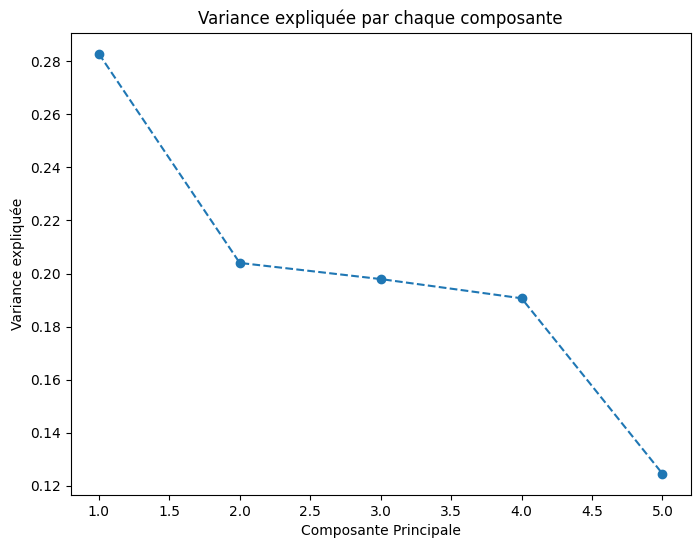

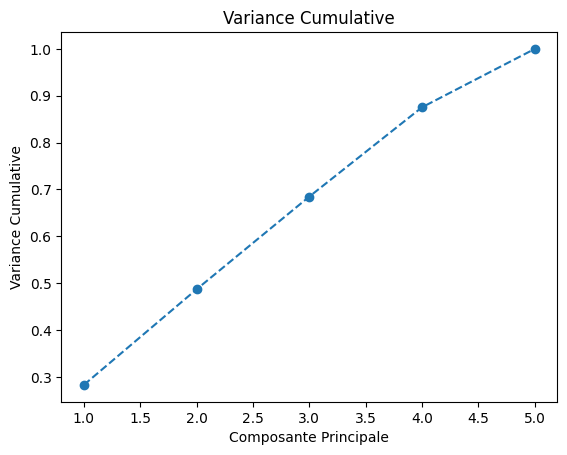

In [76]:
from sklearn.decomposition import PCA

# Appliquer la PCA
pca = PCA()
pca.fit(X_scaled)

# Visualiser la variance expliquée par chaque composante
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title("Variance expliquée par chaque composante")
plt.xlabel("Composante Principale")
plt.ylabel("Variance expliquée")
plt.show()

# Cumul de la variance expliquée pour déterminer le nombre de composantes à garder
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title("Variance Cumulative")
plt.xlabel("Composante Principale")
plt.ylabel("Variance Cumulative")
plt.show()